In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from sklearn.decomposition import PCA

In [2]:
class ManualPCA():
    # Code adpated from https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/
    eigenvectors = None
    eigenvalues = None

    def __init__(self, n_components):
        pass
    
    def fit(self, A):
        M = np.mean(A.T, axis=1) # Calculate mean
        C = A - M # Center
        L = A.T @ A # Doc's little trick
        # The following line yields the error:
        # V = np.cov(C.T, dtype=np.int8) # Calc. cov. matrix
        values, vectors = np.linalg.eig(L) # Extract eigenvectors from cov. matrix
        # Sort values
        np.sort(eigenvalues)
        svecs, svals = sort_eigenstuff(vectors, values) # Reorder eigenvectors/values from most to least important
        self.eigenvectors = svecs
        self.eigenvalues = svals
    
    def transform(self, A):
        M = np.mean(A.T, axis=1)
        C = A - M
        P = self.eigenvectors.T.dot(C.T)
        return P # P or P.T???
    
    def fit_transform(self, A):
        self.fit(A)
        return self.transform(A)

In [3]:
TEST_FOLDER = os.path.join('..', '..', 'test_imgs')

In [15]:
def load_images_from_main_folder(main_folder_path):
    images_per_folder, test_images_per_folder = {}, {}
    folder_names = os.listdir(main_folder_path)
    for folder_name in folder_names:
        folder_path = os.path.join(main_folder_path, folder_name)
        image_names = os.listdir(folder_path)
        # Load and store "train" images
        images_per_image_name = {}
        for image_name in image_names:
            image_path = os.path.join(folder_path, image_name)
            image = imread(image_path)
            images_per_image_name[image_name] = image
        images_per_folder[folder_name] = images_per_image_name
        # Load and store "test" images
        test_images_per_image_name = {}
        for image_name in image_names[-1:]:
            image_path = os.path.join(folder_path, image_name)
            image = imread(image_path)
            test_images_per_image_name[image_name] = image
        test_images_per_folder[folder_name] = test_images_per_image_name
    return images_per_folder, test_images_per_folder

In [16]:
images, test_images = load_images_from_main_folder(TEST_FOLDER)

In [6]:
print(images.keys())

dict_keys(['parking_meter', 'zebra', 'banana', 'traffic_light', 'pizza'])


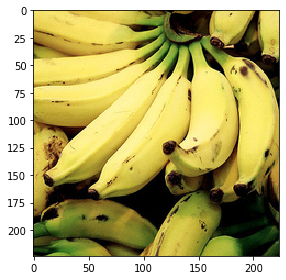

In [7]:
banana_img = test_images['banana']['2413024__banana__1.0.jpg']
imshow(banana_img)

In [24]:
def train_project_pca_on_images(images):
    pca_per_class = {}
    img_data_per_class = {}
    for image_class, image_name_pairs  in images.items():
        # Get image data array from class
        images_data = []
        for _, image in image_name_pairs.items():
            images_data.append(np.reshape(image, newshape=-1))
        images_data = np.array(images_data)
        print(image_class, '-', images_data.shape)
        # Apply PCA and store results
        pca = PCA() # THIS WILL FAIL IF NO. OF SAMPLES IS < 5 (for sklearn's PCA)
        new_images_data = pca.fit_transform(images_data)
        pca_per_class[image_class] = {
            'pca_object' : pca,
            'projections' : new_images_data
        }
        img_data_per_class[image_class] = images_data
    return pca_per_class, img_data_per_class

In [25]:
pca_train_results, images_data = train_project_pca_on_images(images)

parking_meter - (16, 150528)
zebra - (78, 150528)
banana - (6, 150528)
traffic_light - (6, 150528)
pizza - (11, 150528)


In [27]:
images_data['zebra'][0][0]

173

In [29]:
pca_train_results['zebra']

{'pca_object': PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 'projections': array([[  3.66545997e+02,   7.90088956e+03,  -1.46974912e+03, ...,
          -1.45168888e+03,   1.69305851e+03,   2.43424795e-11],
        [  4.67228291e+03,  -4.02957855e+03,   6.76217737e+02, ...,
          -1.31335952e+02,  -3.89519590e+02,   2.43424795e-11],
        [ -5.52495678e+03,  -2.86709278e+03,  -3.55050081e+02, ...,
          -3.38964217e+02,  -2.41956078e+02,   2.43424795e-11],
        ..., 
        [ -6.32773954e+03,  -8.11813132e+03,  -5.59325064e+03, ...,
          -2.07208253e+02,   3.76020978e+01,   2.43424795e-11],
        [  7.61131471e+02,  -3.04773412e+03,   2.20505330e+03, ...,
          -2.00428107e+02,  -4.55286570e+02,   2.43424795e-11],
        [  8.67676940e+03,   6.37630873e+02,  -6.31361832e+03, ...,
          -6.60445497e+02,  -3.01065447e+02,   2.43424795e-11]])}

In [11]:
def get_distance_to_space_prj(image, image_prj):
    reshaped_image = np.reshape(image, newshape=-1)
    return np.linalg.norm(reshaped_image - image_prj)

def project_image_to_space(image, pca_object):
    reshaped_image = np.reshape(image, newshape=(1, -1))
    image_prj = pca_object.transform(reshaped_image)
    no_pad_positions = reshaped_image.shape[1] - image_prj.shape[1]
    image_full_prj = np.append(image_prj, np.zeros(no_pad_positions))
    return image_full_prj

def project_test_images(test_images, pca_train_results):
    # For each class...
    test_results_per_class = {}
    for test_image_class, test_images_pairs in test_images.items():
        # and for each image of each class...
        test_results_per_image = {}
        for test_image_name, test_image in test_images_pairs.items():
            # ...calculate the distances to its different projections...
            test_image_distances = []
            for pca_image_class, pca_data in pca_train_results.items():
                test_image_prj = project_image_to_space(test_image, pca_data['pca_object'])
                dist_to_space = get_distance_to_space_prj(test_image, test_image_prj)
                test_image_distances.append(dist_to_space)
            # ...then determine the nearest class
            test_image_distances = np.array(test_image_distances)
            idx_min = np.argmin(test_image_distances)
            class_min = list(pca_train_results.keys())[idx_min]
            # ...and store the results
            test_results_per_image[test_image_name] = {
                'distances': np.round(test_image_distances, 2),
                'nearest_class': class_min,
                'is_expected_class': class_min == test_image_class
            }
        test_results_per_class[test_image_class] = test_results_per_image
    return test_results_per_class

In [12]:
projection_results = project_test_images(test_images, pca_train_results)

In [13]:
projection_results

{'parking_meter': {'2411372__parking_meter__0.999995.jpg': {'distances': array([ 70366.93,  70677.52,  69712.17,  68354.65,  69706.66]),
   'nearest_class': 'traffic_light',
   'is_expected_class': False}},
 'zebra': {'2411665__zebra__0.99998856.jpg': {'distances': array([ 58714.45,  59271.72,  58753.91,  58267.91,  58809.95]),
   'nearest_class': 'traffic_light',
   'is_expected_class': False}},
 'banana': {'2413024__banana__1.0.jpg': {'distances': array([ 59918.04,  63109.26,  60000.01,  59317.68,  60188.93]),
   'nearest_class': 'traffic_light',
   'is_expected_class': False}},
 'traffic_light': {'2392324__traffic_light__0.9999964.jpg': {'distances': array([ 46849.84,  48928.52,  46044.96,  48168.69,  47000.79]),
   'nearest_class': 'banana',
   'is_expected_class': False}},
 'pizza': {'2392730__pizza__0.9999974.jpg': {'distances': array([ 49062.37,  49122.67,  48747.27,  49017.98,  48670.5 ]),
   'nearest_class': 'pizza',
   'is_expected_class': True}}}

#### Results
* Projected vectors padded with zeroes yield an "accuracy" of 1/5 with respect to expected nearest classes.   
* Tried to perform PCA from scratch, but memory limitations prevented covariance matriz from being calculated.   
* Next step could be to use avg_pooling(windows=(4,4), stride=4) to reduce images down to a (56, 56, 3) shape and then perform PCA.

Someone kill me, please... * sigh *